# APL 104 PROJECT

## 1. Importing the packages

In [559]:
import pandas as pd # for handling the datasets
import numpy as np 

## 2. Loading the datasets

In [562]:
df=pd.read_csv('displacement_data.csv')
df.head()

,x,y,u_x,u_y
0,0.000000,1.000000,0.000000,0.000400
1,0.000000,0.000000,0.000000,0.000000
2,1.000000,0.000000,0.000200,0.000000
3,1.000000,1.000000,0.000200,0.000400
4,0.699605,0.506279,0.000169,0.000213


In [563]:
r_df=pd.read_csv('reaction_data.csv')
r_df.head()

,Reaction,Value
0,R3,-8.527783e+07
1,R4,8.527783e+07
2,R1,-1.015086e+08
3,R2,1.015086e+08


## 3. Data Preprocessing

In [565]:
import numpy as np
from numpy.polynomial.polynomial import Polynomial

x = np.array(df['x'])
y = np.array(df['y'])
ux = np.array(df['u_x'])
uy = np.array(df['u_y'])

degree = 3 # degree of polynomial made 

# first derivatives
p_ux_x = Polynomial.fit(x, ux, deg=degree)
p_uy_x = Polynomial.fit(x, uy, deg=degree)
dux_dx = p_ux_x.deriv()(x)
duy_dx = p_uy_x.deriv()(x)

p_ux_y = Polynomial.fit(y, ux, deg=degree)
p_uy_y = Polynomial.fit(y, uy, deg=degree)
dux_dy = p_ux_y.deriv()(y)
duy_dy = p_uy_y.deriv()(y)

df['dux_dx'] = dux_dx
df['duy_dx'] = duy_dx
df['dux_dy'] = dux_dy
df['duy_dy'] = duy_dy

# second derivatives
d2ux_dx2 = p_ux_x.deriv(2)(x)
d2uy_dy2 = p_uy_y.deriv(2)(y)
d2ux_dy2 = p_ux_y.deriv(2)(y)
d2uy_dx2 = p_uy_x.deriv(2)(x)

df['d2ux_dx2'] = d2ux_dx2
df['d2uy_dy2'] = d2uy_dy2
df['d2ux_dy2'] = d2ux_dy2
df['d2uy_dx2'] = d2uy_dx2

d2ux_dxdy = p_ux_x.deriv(2)(y)
d2uy_dydx = p_uy_y.deriv(2)(x)
d2ux_dydx = p_ux_y.deriv(2)(x)
d2uy_dxdy = p_uy_x.deriv(2)(y)

df['d2ux_dxdy'] = d2ux_dxdy
df['d2uy_dydx'] = d2uy_dydx
df['d2ux_dydx'] = d2ux_dydx
df['d2uy_dxdy'] = d2uy_dxdy

df.tail()


,x,y,u_x,u_y,dux_dx,duy_dx,dux_dy,duy_dy,d2ux_dx2,d2uy_dy2,d2ux_dy2,d2uy_dx2,d2ux_dxdy,d2uy_dydx,d2ux_dydx,d2uy_dxdy
3872,0.290081,0.496225,0.000037,0.000195,0.000242,-0.000004,-0.000005,0.000608,0.000609,0.000022,-0.000005,-0.000109,0.000011,0.001218,-0.000028,-0.000008
3873,0.704787,0.473860,0.000164,0.000164,0.000245,-0.000007,-0.000005,0.000606,-0.000594,0.000152,-0.000008,0.000095,0.000076,-0.001189,0.000017,-0.000019
3874,0.709291,0.496264,0.000164,0.000195,0.000242,-0.000007,-0.000005,0.000608,-0.000607,0.000022,-0.000005,0.000097,0.000011,-0.001215,0.000018,-0.000008
3875,0.692144,0.452789,0.000165,0.000131,0.000252,-0.000009,-0.000005,0.000601,-0.000557,0.000274,-0.000010,0.000089,0.000137,-0.001115,0.000016,-0.000029
3876,0.308884,0.453679,0.000036,0.000131,0.000253,-0.000006,-0.000005,0.000602,0.000554,0.000269,-0.000010,-0.000100,0.000134,0.001109,-0.000025,-0.000029


In [566]:
sigma_xx_known = -r_df['Value'][1]
sigma_yy_known = -r_df['Value'][3] # equating the values of boundary stresses to the negative of the reactions

## 4. Define Objective function which will give the cost function

In [568]:
def objective(params):
    lambda_, mu = params
    total_residual=0

    # residual based on the equilibrium equations
    residual_1 = (lambda_ + 2 * mu) * df['d2ux_dx2'] + mu * df['d2ux_dy2'] + (lambda_ + mu) * df['d2uy_dxdy']
    residual_2 = (lambda_ + 2 * mu) * df['d2uy_dy2'] + mu * df['d2uy_dx2'] + (lambda_ + mu) * df['d2ux_dydx']
    eqm_residual_1 = np.sum((residual_1)**2) * 1e-18
    eqm_residual_2 = np.sum((residual_2)**2) * 1e-18 # for scaling

    eqm_residual = eqm_residual_1 + eqm_residual_2

    # residual based on the boundary conditions of stress 
    sigma_xx_residual = lambda_ * (df['dux_dx'][df['x']==1] + df['duy_dy'][df['x']==1]) + 2 * mu * df['dux_dx'][df['x']==1] - sigma_xx_known
    sigma_yy_residual = lambda_ * (df['dux_dx'][df['y']==1] + df['duy_dy'][df['y']==1]) + 2 * mu * df['duy_dy'][df['y']==1] - sigma_yy_known
    stress_residual_xx = np.sum(sigma_xx_residual**2) * 1e-18
    stress_residual_yy = np.sum(sigma_yy_residual**2) * 1e-18 # for scaling

    # Total stress residual
    stress_residual = stress_residual_xx + stress_residual_yy

    #total cost function
    total_residual = eqm_residual + stress_residual
    
    print(f"Lambda: {lambda_}, Mu: {mu}, Total Residual: {total_residual}")
    
    return total_residual

## 5. Optimization Model - Differential evolution

In [574]:
from scipy.optimize import differential_evolution  # model and syntax consulted from AI (ChatGPT)
initial_guess = [1e11, 1e11]
bounds = [(1e9, 1e12), (1e9, 1e12)]

result = differential_evolution(objective, bounds, strategy='best1bin', tol=1)

lam_opt, mu_opt = result.x
print("Optimized Lame's constants:")
print(f"Lambda: {lam_opt}")
print(f"Mu: {mu_opt}")
print(f"Final Objective (Residual): {result.fun}")

Lambda: 5592524513.072571, Mu: 935931120303.3065, Total Residual: 51760.41475345002
Lambda: 36953533794.6167, Mu: 708011996598.0847, Total Residual: 31000.647963818017
Lambda: 844097557013.3022, Mu: 173152101407.1548, Total Residual: 20833.513883318003
Lambda: 79630128435.14569, Mu: 569662806481.1453, Total Residual: 21818.636146197714
Lambda: 288693480303.2711, Mu: 808434439517.8535, Total Residual: 53322.18619375253
Lambda: 776635191942.865, Mu: 370885726104.8961, Total Residual: 33874.37271547344
Lambda: 701441707656.1104, Mu: 80861996360.7818, Total Residual: 10959.466033938961
Lambda: 424409541785.0327, Mu: 855806537648.6069, Total Residual: 67001.53459824435
Lambda: 906072447296.8, Mu: 12564437412.878845, Total Residual: 12764.506555383972
Lambda: 322690398712.8494, Mu: 751948219613.8538, Total Residual: 48994.57722323537
Lambda: 344516204437.89557, Mu: 509601463427.57007, Total Residual: 27311.6919860547
Lambda: 984832906279.3005, Mu: 552218198230.3435, Total Residual: 64125.601

## 6. Calculation of Stress using Optimized Lame's constants

In [577]:
df['sigma_xx'] = lam_opt * (df['dux_dx'] + df['duy_dy']) + 2 * mu_opt * df['dux_dx']
df['sigma_yy'] = lam_opt * (df['duy_dy'] + df['dux_dx']) + 2 * mu_opt * df['duy_dy']
df['tau_xy'] = mu_opt * (df['dux_dy'] + df['duy_dx'])
df.head()

,x,y,u_x,u_y,dux_dx,duy_dx,dux_dy,duy_dy,d2ux_dx2,d2uy_dy2,d2ux_dy2,d2uy_dx2,d2ux_dxdy,d2uy_dydx,d2ux_dydx,d2uy_dxdy,sigma_xx,sigma_yy,tau_xy
0,0.000000,1.000000,0.000000,0.000400,-0.000056,0.000048,0.000006,-0.000118,0.001450,-0.002902,0.000049,-0.000252,-0.001450,0.002902,-0.000059,0.000240,-6.775729e+06,-7.144583e+06,162240.864139
1,0.000000,0.000000,0.000000,0.000000,-0.000056,0.000048,0.000011,-0.000118,0.001450,0.002902,-0.000059,-0.000252,0.001450,0.002902,-0.000059,-0.000252,-6.773785e+06,-7.142323e+06,177087.479739
2,1.000000,0.000000,0.000200,0.000000,-0.000057,0.000042,0.000011,-0.000118,-0.001450,0.002902,-0.000059,0.000240,0.001450,-0.002902,0.000049,-0.000252,-6.779080e+06,-7.146876e+06,158990.364932
3,1.000000,1.000000,0.000200,0.000400,-0.000057,0.000042,0.000006,-0.000118,-0.001450,-0.002902,0.000049,0.000240,-0.001450,-0.002902,0.000049,0.000240,-6.781023e+06,-7.149136e+06,144143.749333
4,0.699605,0.506279,0.000169,0.000213,0.000248,-0.000008,-0.000005,0.000608,-0.000579,-0.000037,-0.000004,0.000092,-0.000018,-0.001159,0.000017,-0.000003,3.312756e+07,3.529461e+07,-39382.766970


## 7. Plotting a heatmap of the values obtained

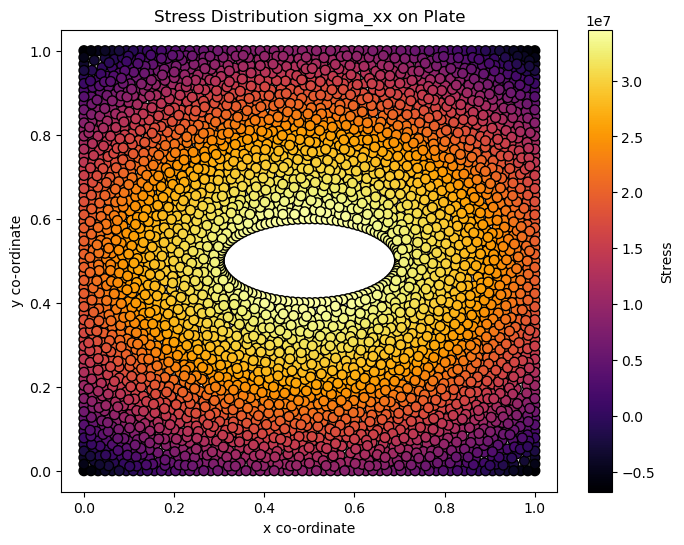

In [580]:
import matplotlib.pyplot as plt #'inferno' map syntax consulted from AI(ChatGPT)

x = df['x']  
y = df['y'] 
stress = df['sigma_xx']  

plt.figure(figsize=(8, 6))
sc = plt.scatter(x, y, c=stress, cmap='inferno', s=50, edgecolor='k')
plt.colorbar(sc, label='Stress') 

plt.xlabel('x co-ordinate')
plt.ylabel('y co-ordinate')
plt.title('Stress Distribution sigma_xx on Plate')
plt.show()

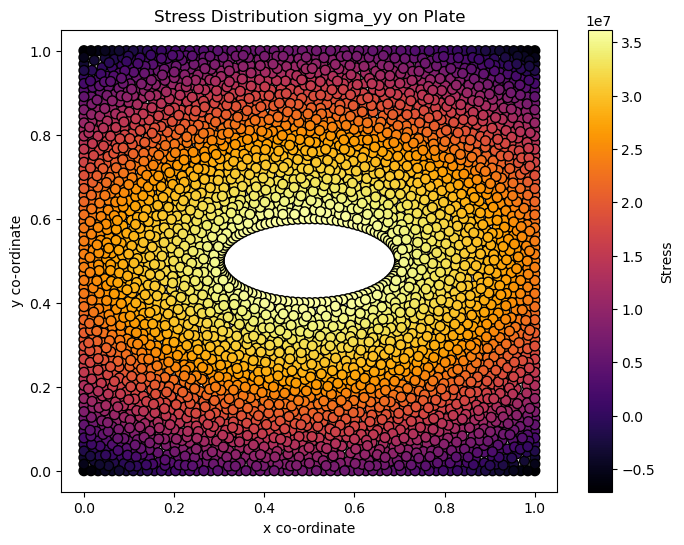

In [581]:
import matplotlib.pyplot as plt

x = df['x'] 
y = df['y']  
stress = df['sigma_yy']  

plt.figure(figsize=(8, 6))
sc = plt.scatter(x, y, c=stress, cmap='inferno', s=50, edgecolor='k')
plt.colorbar(sc, label='Stress')  

plt.xlabel('x co-ordinate')
plt.ylabel('y co-ordinate')
plt.title('Stress Distribution sigma_yy on Plate')
plt.show()

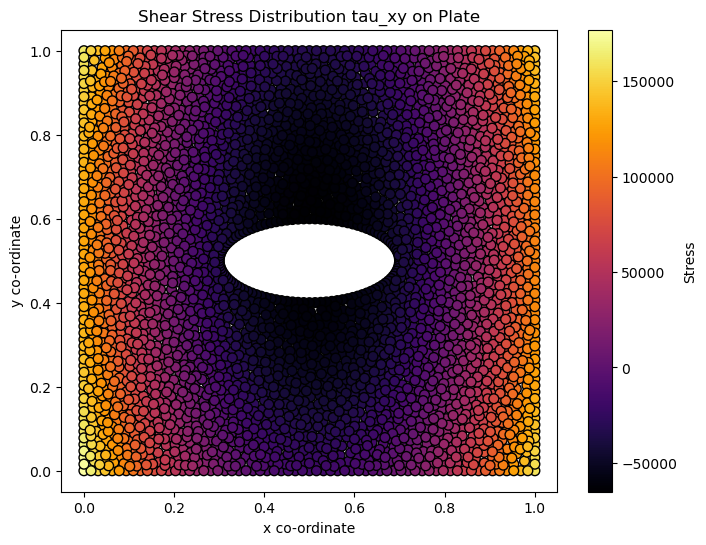

In [583]:
import matplotlib.pyplot as plt

x = df['x'] 
y = df['y']  
stress = df['tau_xy']  

plt.figure(figsize=(8, 6))
sc = plt.scatter(x, y, c=stress, cmap='inferno', s=50, edgecolor='k')
plt.colorbar(sc, label='Stress')  

plt.xlabel('x co-ordinate')
plt.ylabel('y co-ordinate')
plt.title('Shear Stress Distribution tau_xy on Plate')
plt.show()

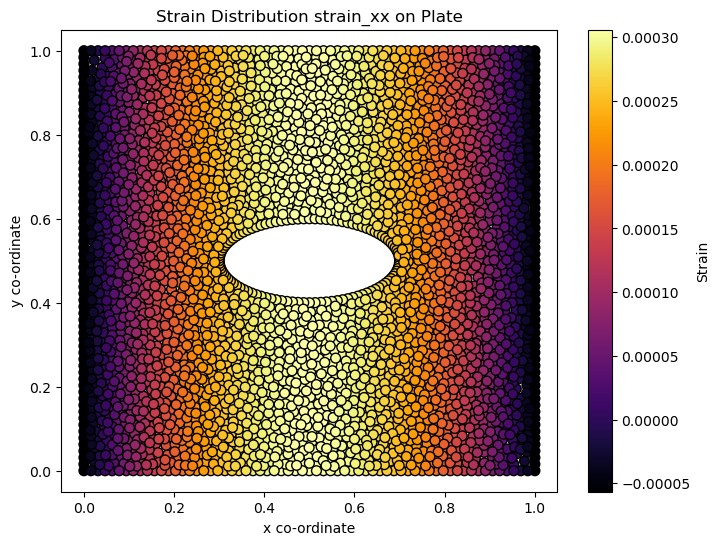

In [584]:
import matplotlib.pyplot as plt

x = df['x'] 
y = df['y']  
strain = df['dux_dx']  

plt.figure(figsize=(8, 6))
sc = plt.scatter(x, y, c=strain, cmap='inferno', s=50, edgecolor='k')
plt.colorbar(sc, label='Strain')  

plt.xlabel('x co-ordinate')
plt.ylabel('y co-ordinate')
plt.title('Strain Distribution strain_xx on Plate')
plt.show()

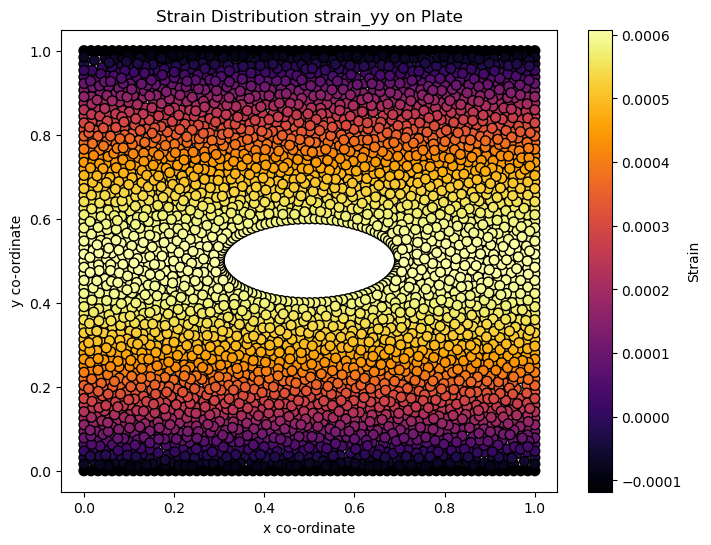

In [585]:
import matplotlib.pyplot as plt

x = df['x'] 
y = df['y']  
strain = df['duy_dy']  

plt.figure(figsize=(8, 6))
sc = plt.scatter(x, y, c=strain, cmap='inferno', s=50, edgecolor='k')
plt.colorbar(sc, label='Strain')  

plt.xlabel('x co-ordinate')
plt.ylabel('y co-ordinate')
plt.title('Strain Distribution strain_yy on Plate')
plt.show()

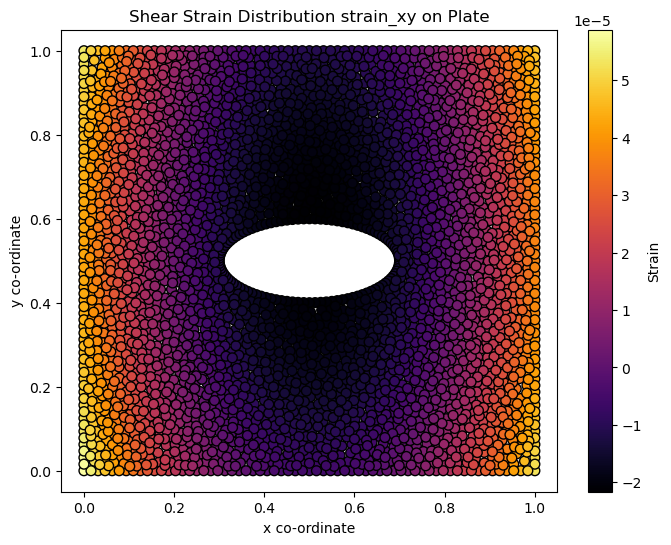

In [586]:
import matplotlib.pyplot as plt

x = df['x'] 
y = df['y']  
strain = df['dux_dy']+ df['duy_dx']  # engineering strain

plt.figure(figsize=(8, 6))
sc = plt.scatter(x, y, c=strain, cmap='inferno', s=50, edgecolor='k')
plt.colorbar(sc, label='Strain')  

plt.xlabel('x co-ordinate')
plt.ylabel('y co-ordinate')
plt.title('Shear Strain Distribution strain_xy on Plate')
plt.show()